In [1]:
! pip install -r requirements.txt

  Using cached scikit_learn-1.2.2-cp39-cp39-win_amd64.whl (8.4 MB)
  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)
  Using cached tbb-2021.13.1-py3-none-win_amd64.whl (286 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl (3.5 MB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import tensorboard
from tensorboard import notebook
import time
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## EDA

In [4]:
df = pd.read_csv("data/alzheimers_prediction_dataset.csv")

In [5]:
df.head()

,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,...,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,...,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,...,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,...,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


In [6]:
size = df.shape[0]
print(size)

74283


In [7]:
TARGET_COL = "Alzheimer’s Diagnosis"

print("\n===== Basic Info =====")
print(df.info())

print("\n===== Value counts of Target =====")
print(df[TARGET_COL].value_counts())

print("\n===== Numeric Describe =====")
print(df.describe())


===== Basic Info =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  obje

No null values

Some range in values, will use standard scalar to fix this because there is no reason to not use another (not a big range, not highly skewed)

Check distribution of target label

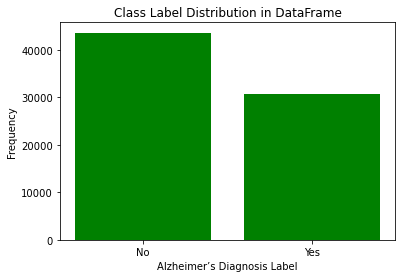

In [8]:
value_counts = df["Alzheimer’s Diagnosis"].value_counts()
label, count = list(value_counts.index), value_counts.values
plt.bar(label, count, color="green")
plt.xlabel('Alzheimer’s Diagnosis Label')
plt.ylabel('Frequency')
plt.title('Class Label Distribution in DataFrame')
plt.xticks(label)  # Set x-ticks to be the class labels
plt.show()

Need to fix balance of data

In [9]:
if "Country" in df.columns:
    df = df.drop(columns=["Country"], errors="ignore")

X = df.drop(columns=[TARGET_COL], errors="ignore")
y = df[TARGET_COL]

print("\nShapes BEFORE train/test split:")
print("X shape:", X.shape, "y shape:", y.shape)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nShapes AFTER train/test split:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)
print("\n===== Value counts of Target =====")
print(y_train.value_counts())

# Oversample
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Reset indices to avoid out-of-bounds errors
X_train_res = X_train_res.reset_index(drop=True)
y_train_res = y_train_res.reset_index(drop=True)

meta_train = y_train_res.values
meta_test = y_test.values

print("\nShapes AFTER Oversampling (train only):")
print("X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)
print("\n===== Value counts of Target =====")
print(y_train_res.value_counts())


Shapes BEFORE train/test split:
X shape: (74283, 23) y shape: (74283,)

Shapes AFTER train/test split:
X_train: (59426, 23) y_train: (59426,)
X_test:  (14857, 23) y_test:  (14857,)

===== Value counts of Target =====
No     34856
Yes    24570
Name: Alzheimer’s Diagnosis, dtype: int64

Shapes AFTER Oversampling (train only):
X_train_res: (69712, 23) y_train_res: (69712,)

===== Value counts of Target =====
No     34856
Yes    34856
Name: Alzheimer’s Diagnosis, dtype: int64


In [10]:
# 3) Numeric & Categorical Processing
numeric_cols = ["Age", "Education Level", "BMI", "Cognitive Test Score"]
categorical_cols = list(set(X_train_res.columns) - set(numeric_cols))
for col in numeric_cols:
    if col not in X_train_res.columns:
        print(f"Warning: numeric column '{col}' not found in X_train_res.")

# Scale numeric features
scaler = StandardScaler()
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])

# Transform test set
if set(numeric_cols).issubset(X_test.columns):
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# One-Hot encode categorical
print("\n===== One-Hot Encoding =====")
print("Categorical columns:", categorical_cols)
X_train_res = pd.get_dummies(X_train_res, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
X_test = X_test.reindex(columns=X_train_res.columns, fill_value=0)

# Convert target to 0/1
y_train_res_bin = (y_train_res == "Yes").astype(int)
y_test_bin = (y_test == "Yes").astype(int)

print("\nFinal training data shape:", X_train_res.shape, y_train_res_bin.shape)
print("Final testing data shape: ", X_test.shape,  y_test_bin.shape)


===== One-Hot Encoding =====
Categorical columns: ['Hypertension', 'Stress Levels', 'Sleep Quality', 'Family History of Alzheimer’s', 'Income Level', 'Smoking Status', 'Employment Status', 'Alcohol Consumption', 'Depression Level', 'Genetic Risk Factor (APOE-ε4 allele)', 'Air Pollution Exposure', 'Diabetes', 'Marital Status', 'Cholesterol Level', 'Urban vs Rural Living', 'Social Engagement Level', 'Physical Activity Level', 'Dietary Habits', 'Gender']

Final training data shape: (69712, 35) (69712,)
Final testing data shape:  (14857, 35) (14857,)


Had two datasets at first, one with label encoding and one with one-hot encoding. After initial model tests, the label encoding model did not improve accuracy or computation, so one-hot encoding was used. 

In [11]:
X_train_res.head()

,Age,Education Level,BMI,Cognitive Test Score,Hypertension_Yes,Stress Levels_Low,Stress Levels_Medium,Sleep Quality_Good,Sleep Quality_Poor,Family History of Alzheimer’s_Yes,...,Marital Status_Widowed,Cholesterol Level_Normal,Urban vs Rural Living_Urban,Social Engagement Level_Low,Social Engagement Level_Medium,Physical Activity Level_Low,Physical Activity Level_Medium,Dietary Habits_Healthy,Dietary Habits_Unhealthy,Gender_Male
0,-0.531819,0.955143,-1.230785,0.809079,1,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1
1,1.399337,-0.086543,0.888366,0.660039,0,0,1,1,0,0,...,1,1,0,0,1,0,1,1,0,0
2,-0.222834,-1.649072,-0.874096,1.603961,0,0,0,0,0,0,...,0,1,1,1,0,0,1,1,0,1
3,-0.222834,-0.607386,1.580762,0.660039,0,0,0,0,1,1,...,1,1,1,0,0,0,0,0,0,1
4,-0.454573,-0.086543,0.174988,-1.525886,1,1,0,1,0,1,...,0,1,0,1,0,0,0,1,0,0


In [12]:
X_train_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69712 entries, 0 to 69711
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       69712 non-null  float64
 1   Education Level                           69712 non-null  float64
 2   BMI                                       69712 non-null  float64
 3   Cognitive Test Score                      69712 non-null  float64
 4   Hypertension_Yes                          69712 non-null  uint8  
 5   Stress Levels_Low                         69712 non-null  uint8  
 6   Stress Levels_Medium                      69712 non-null  uint8  
 7   Sleep Quality_Good                        69712 non-null  uint8  
 8   Sleep Quality_Poor                        69712 non-null  uint8  
 9   Family History of Alzheimer’s_Yes         69712 non-null  uint8  
 10  Income Level_Low                  

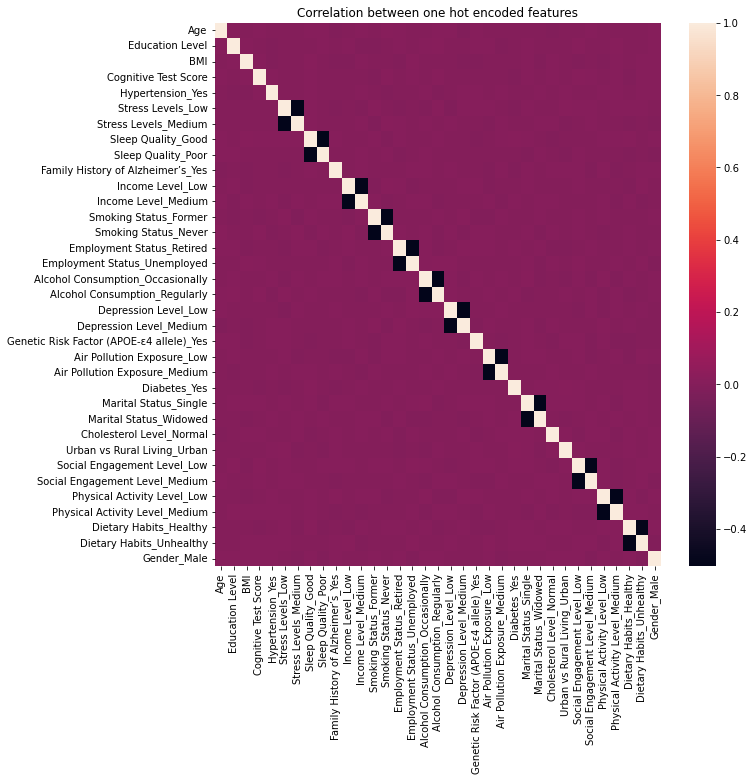

In [13]:
corr = X_train_res.corr() # heat map of correlation
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax)
plt.title("Correlation between one hot encoded features")
plt.show()

There is some correlation between features, but it is usually between features like Physical Activity_Low and Physical Activity_Medium. I do not think it is worth removing these features as it could negatively impact the result. The correlation between these features is greater than -0.4 (close to 0). There are no other features correlated closely. However, there is some correlation between Age and the target variable. This should be monitored when evaluating the model.

## Dataset/Dataloader Creation

In [14]:
# 4) Convert to float32 & Build Dataset / DataLoader
print("\nConverting DataFrames to float32...")
X_train_res = X_train_res.astype("float32")
X_test = X_test.astype("float32")
print("Conversion done.")

class BinaryDataset(Dataset):
    def __init__(self, data, labels, meta):
        self.data = torch.tensor(data.values, dtype=torch.float32)  # Convert to tensor
        self.labels = torch.tensor(labels.values, dtype=torch.float32)  # Convert to tensor
        self.meta = meta

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.meta[idx]


Converting DataFrames to float32...
Conversion done.


In [15]:
print("Creating train_dataset...")
train_dataset = BinaryDataset(X_train_res, y_train_res_bin, meta_train)
print("Creating test_dataset...")
test_dataset  = BinaryDataset(X_test, y_test_bin, meta_test)

print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))

Creating train_dataset...
Creating test_dataset...
Train dataset length: 69712
Test dataset length: 14857


In [16]:
def manual_iteration_check(ds, n=5):
    print(f"\nChecking first {n} samples in dataset ...")
    for i in range(n):
        features, label, meta = ds.__getitem__(i)
        print(f"Index={i}, features shape={features.shape}, label={label}, meta={meta}")

In [17]:
manual_iteration_check(train_dataset, n=5)


Checking first 5 samples in dataset ...
Index=0, features shape=torch.Size([35]), label=0.0, meta=No
Index=1, features shape=torch.Size([35]), label=1.0, meta=Yes
Index=2, features shape=torch.Size([35]), label=0.0, meta=No
Index=3, features shape=torch.Size([35]), label=1.0, meta=Yes
Index=4, features shape=torch.Size([35]), label=0.0, meta=No


In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [19]:
train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))

train_batch_shape = (train_batch[0].shape, train_batch[1].shape)
test_batch_shape = (test_batch[0].shape, test_batch[1].shape)

train_batch_shape, test_batch_shape

((torch.Size([64, 35]), torch.Size([64])),
 (torch.Size([64, 35]), torch.Size([64])))

Create binary MLP class

In [20]:
class BinaryMLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        #self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.LeakyReLU(0.1)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 32)
        #self.bn3 = nn.BatchNorm1d(32)
        self.relu3 = nn.LeakyReLU(0.1)
        self.fc4 = nn.Linear(32, 32)
        self.relu4 = nn.LeakyReLU(0.1)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        #out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.bn2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        #out = self.bn3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.bn4(out)
        emb = self.fc5(out)
        out = self.sigmoid(emb)
        return out, emb  # shape (batch_size, 1)

Training loop

In [ ]:
# Taken from Lecture03_MLP and Lecture09_CNN_RGB_Tensorboard in class repository

from torch.utils.tensorboard import SummaryWriter

# initialize tensorboard writer
# CHANGE LOG FOR EACH DAY
writer = SummaryWriter(log_dir='runs/model_training/feb20/')

# Training Loop for PyTorch Model

def train(model, loss_fn, optimizer, train_loader, batch_size=64, epochs=5, threshold=0.5, test_loader=None):
    """
    A function to train a PyTorch model.
    It teaches the model to predict answers correctly by repeatedly learning from mistakes.
    
    Args:
    - model: The machine learning model to be trained.
    - loss_fn: The function that calculates how wrong the model's predictions are (loss function).
    - optimizer: The helper that adjusts the model to improve predictions (optimizer).
    - batch_size: How many examples to process at a time (default is 64).
    - epochs: How many rounds of learning the model will go through (default is 5).
    """

    # log model graph
    sample_input = torch.randn(64, 35).to(device) ## adjust to model input
    try:
        writer.add_graph(model, sample_input)
        print("Model sucessfully logged in TensorBoard!")
    except Exception as e:
        print(f"Error while logging model graph: {e}")

    model.train()  # Set the model to 'training mode' so it can learn and improve.

    start_time = time.time()

    for epoch in range(epochs):  # Loop through each learning round (epoch).
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for i, (inputs, labels, meta) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            # Track training loss & accuracy
            running_loss += loss.item()
            preds = np.array((outputs.squeeze().cpu() >= threshold)).astype(int)
            correct_train += (torch.tensor(preds).to(device) == labels).sum().item()
            total_train += labels.size(0)

            # log loss every 100 batches
            if (i + 1) % 100 == 0:
                writer.add_scalar("Training Loss", loss.item(), epoch * len(train_loader) + i)

        # Compute epoch loss & accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # validation phase if test loader is provided
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        if test_loader:
            model.eval()
            with torch.no_grad():
                for inputs, labels, meta in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs, _ = model(inputs)
                    loss = loss_fn(outputs.squeeze(), labels)

                    val_loss += loss.item()
                    preds = (outputs.squeeze() >= threshold).int()
                    correct_val += (preds == labels).sum().item()
                    total_val += labels.size(0)

            val_loss /= len(test_loader)
            val_accuracy = correct_val / total_val
        else:
            val_loss = 0.0
            val_accuracy = 0.0

        
        # Log metrics to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
        if test_loader:
            writer.add_scalar("Loss/Validation", val_loss, epoch)
            writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

        # Log model parameters
        for name, param in model.named_parameters():
            writer.add_histogram(name, param, epoch)
        
        # Print how much the model improved in this round.
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    end_time = time.time()
    print(f"\n🚀 Training Completed in {end_time - start_time:.2f} seconds")

    # Close the TensorBoard writer
    writer.close()


In [27]:
# load previous model
model = BinaryMLP(35)
model.load_state_dict(torch.load("model.pth", weights_only=False))

<All keys matched successfully>

In [28]:
#model = BinaryMLP(35)
print(model)

BinaryMLP(
  (fc1): Linear(in_features=35, out_features=64, bias=True)
  (relu1): LeakyReLU(negative_slope=0.1)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): LeakyReLU(negative_slope=0.1)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (relu3): LeakyReLU(negative_slope=0.1)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (relu4): LeakyReLU(negative_slope=0.1)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [29]:
# launch tensorboard
%reload_ext tensorboard

# Launch TensorBoard
%tensorboard --logdir='runs/model_training/feb21'

Reusing TensorBoard on port 6007 (pid 35072), started 0:29:35 ago. (Use '!kill 35072' to kill it.)

Hyperparameters and Train

In [ ]:
lr = 0.01
epochs = 30
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train(model, loss_fn, optimizer, train_loader, batch_size, epochs, test_loader=test_loader)

Model sucessfully logged in TensorBoard!
Epoch [1/20] | Train Loss: 0.5814, Train Acc: 0.7095 | Val Loss: 0.5559, Val Acc: 0.7209
Epoch [2/20] | Train Loss: 0.5592, Train Acc: 0.7212 | Val Loss: 0.5534, Val Acc: 0.7199
Epoch [3/20] | Train Loss: 0.5553, Train Acc: 0.7219 | Val Loss: 0.5589, Val Acc: 0.7156
Epoch [4/20] | Train Loss: 0.5527, Train Acc: 0.7231 | Val Loss: 0.5516, Val Acc: 0.7180
Epoch [5/20] | Train Loss: 0.5508, Train Acc: 0.7242 | Val Loss: 0.5469, Val Acc: 0.7205
Epoch [6/20] | Train Loss: 0.5490, Train Acc: 0.7248 | Val Loss: 0.5481, Val Acc: 0.7206
Epoch [7/20] | Train Loss: 0.5479, Train Acc: 0.7250 | Val Loss: 0.5483, Val Acc: 0.7184
Epoch [8/20] | Train Loss: 0.5465, Train Acc: 0.7257 | Val Loss: 0.5537, Val Acc: 0.7149


Loss seems to be capping at .55, accuracy at .71

Changing lr to be higher and activation leaky ReLU lead to slight overfitting

Making model deeper seemingly has no change

Tried moving batch normalization after ReLU, changing all ReLU to leaky, lr to 0.0001, changing depth and width, but model still converges at .55 loss and .71 accuracy

Inference

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# function for seeing the model's accuracy on the test set
def test(model, test_loader, threshold=0.5):
    # Running inference
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []


    with torch.no_grad():
        for inputs, labels, _ in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
            outputs, _ = model(inputs)
            preds = (outputs.squeeze().cpu().numpy() >= threshold).astype(int)  # Move to CPU for numpy
            total += labels.size(0)
            correct += (preds == labels.cpu().numpy()).sum().item()  # Move labels to CPU
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds)


    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")
    
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


    acc  = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score(labels, preds, zero_division=0)
    f1   = f1_score(labels, preds, zero_division=0)
    auc  = roc_auc_score(labels, outputs.cpu().numpy())

    print("\n--- Evaluation Results ---")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"AUC:       {auc:.3f}")

Accuracy: 66.09%


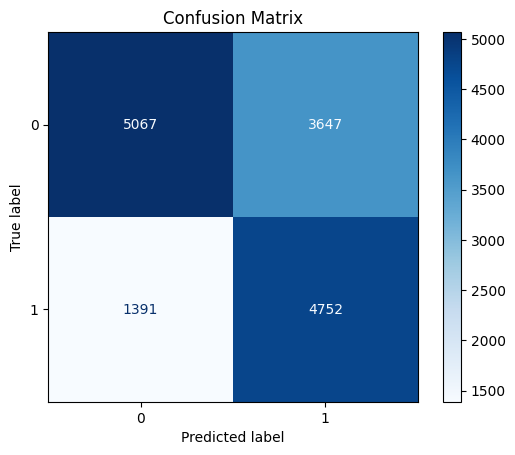


--- Evaluation Results ---
Accuracy:  0.556
Precision: 0.429
Recall:    1.000
F1 Score:  0.600
AUC:       0.833


In [ ]:
test(model, test_loader)

Pre built accuracy, precision, etc. functions are different from manual calculations (???)

Confusion matrix shows better predictions for not having Alzeimer's. This means we are have more false positives and saying more people have Alzheimer's than in reality.

Usually have 5700 true 0, 3000 false 0 (actual 0 pred 1), 1300 false 1 (actual 1 pred 0), and 4800 true 1

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Final model saved.")

Final model saved.


## SHAP Evaluation

In [ ]:
import shap

In [ ]:
class ModelWrapper(nn.Module):
    def __init__(self, base_model):
        super(ModelWrapper, self).__init__()
        self.base_model = base_model  # your trained model
        
    def forward(self, x):
        logits, _ = self.base_model(x)
        return logits

In [ ]:
model_wrapper = ModelWrapper(model).to(device)
# Ensure the wrapper model is in evaluation mode.
model_wrapper.eval()

ModelWrapper(
  (base_model): BinaryMLP(
    (fc1): Linear(in_features=35, out_features=64, bias=True)
    (relu1): LeakyReLU(negative_slope=0.1)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (relu2): LeakyReLU(negative_slope=0.1)
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc3): Linear(in_features=32, out_features=32, bias=True)
    (relu3): LeakyReLU(negative_slope=0.1)
    (fc4): Linear(in_features=32, out_features=32, bias=True)
    (relu4): LeakyReLU(negative_slope=0.1)
    (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc5): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [ ]:
num_features = X_train_res.columns
# Create a background sample from the training data.
X_train_res = X_train_res.astype("float32")
background = torch.tensor(
    X_train_res.sample(100, replace=False, random_state=42).values,
    dtype=torch.float32
).to(device)

In [ ]:
# Choose one test sample to explain.
X_test = X_test.astype("float32")
sample_to_explain = torch.tensor(X_test[0:1].values, dtype=torch.float32).to(device)

# Try using DeepExplainer; if it fails, fall back to GradientExplainer.
try:
    explainer = shap.DeepExplainer(model_wrapper, background)
    shap_values = explainer.shap_values(sample_to_explain)
    expected_value = explainer.expected_value
except AssertionError as e:
    print("DeepExplainer encountered an error:", e)
    print("Falling back to GradientExplainer.")
    explainer = shap.GradientExplainer(model_wrapper, background)
    shap_values = explainer.shap_values(sample_to_explain)
    # Compute the expected value as the mean model output on the background.
    bg_preds = model_wrapper(background).cpu().detach().numpy()
    expected_value = np.mean(bg_preds, axis=0)
    

# If shap_values is a list, convert it to a NumPy array.
if isinstance(shap_values, list):
    shap_values = np.array(shap_values)
    
shap.initjs()
shap.plots.force(expected_value[0], shap_values[..., 0], feature_names=num_features)

In [ ]:
print(y_test[0:1])

18353    Yes
Name: Alzheimer’s Diagnosis, dtype: object


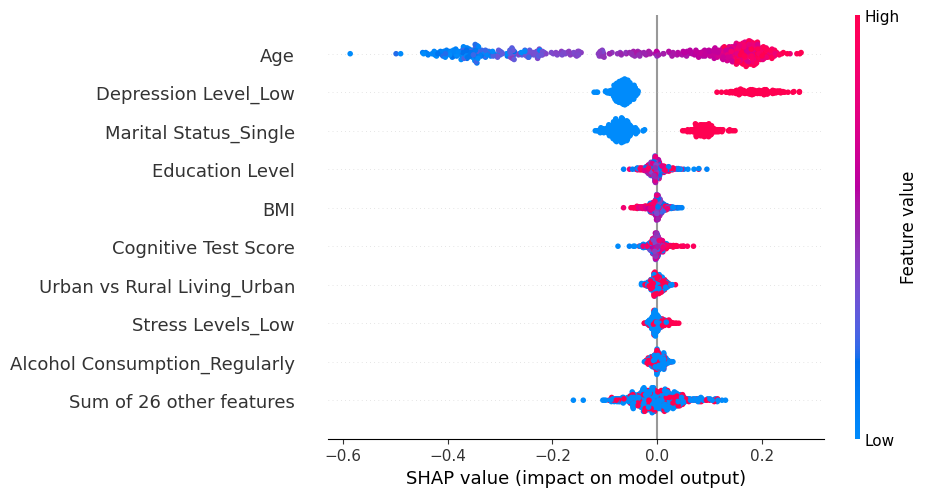

In [ ]:
# Use a subset (e.g., the first 50 samples) from the test set for the beeswarm plot.
subset_size = 500
X_subset = torch.tensor(
    X_train_res.sample(subset_size, replace=False, random_state=42).values, 
    dtype=torch.float32).to(device)

# Compute SHAP values for the subset.
try:
    explainer_subset = shap.DeepExplainer(model_wrapper, background)
    shap_values_subset = explainer_subset.shap_values(X_subset)
    expected_value_subset = explainer_subset.expected_value
except AssertionError as e:
    print("DeepExplainer encountered an error on subset:", e)
    print("Falling back to GradientExplainer for subset.")
    explainer_subset = shap.GradientExplainer(model_wrapper, background)
    shap_values_subset = explainer_subset.shap_values(X_subset)
    bg_preds_subset = model_wrapper(background).cpu().detach().numpy()
    expected_value_subset = np.mean(bg_preds_subset, axis=0)
    
# If shap_values_subset is returned as a list (common for multi-output models),
# extract the explanation for the first output (or the only output if length is 1).
if isinstance(shap_values_subset, list):
    if len(shap_values_subset) == 1:
        shap_values_array = shap_values_subset[0]
    else:
        shap_values_array = shap_values_subset[0]
else:
    shap_values_array = shap_values_subset
    
# If the resulting array has more than 2 dimensions, select the first slice along the output dimension.
if len(shap_values_array.shape) > 2:
    shap_values_beeswarm = shap_values_array[..., 0]
else:
    shap_values_beeswarm = shap_values_array    

# IMPORTANT: Create a SHAP Explanation object that includes the original feature data.
# Passing the data allows the beeswarm plot to color the points based on feature values.
explanation = shap.Explanation(
    values=shap_values_beeswarm, 
    data=X_subset.cpu().numpy(), 
    feature_names=num_features
)

# Plot the beeswarm plot without forcing a constant color.
shap.initjs()
shap.plots.beeswarm(explanation)

## Embeddings

In [ ]:
from tensorboard.plugins import projector

In [ ]:
def log_embeddings(model, path, test_loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    all_meta = []  # Will store metadata as a list-of-lists: [Genre, Artist, Album]

    # Process the test set using the DataLoader defined earlier.
    with torch.no_grad():
        for X_batch, y_batch, meta_batch in test_loader:
            X_batch = X_batch.to(device)
            _, emb = model(X_batch)
            all_embeddings.append(emb.cpu())
            all_labels.append(y_batch)
            for meta in meta_batch:
                fields = meta.split("\t")
                label = fields[0] if len(fields) >= 1 else "Unknown"
                all_meta.append([label])

    embeddings_tensor = torch.cat(all_embeddings, dim=0)
    labels_tensor = torch.cat(all_labels, dim=0)

    # Ensure that the number of metadata rows equals the number of embeddings.
    num_embeddings = embeddings_tensor.shape[0]
    if len(all_meta) < num_embeddings:
        diff = num_embeddings - len(all_meta)
        print(f"Metadata is missing {diff} entries. Appending dummy rows.")
        all_meta.extend([["Unknown", "Unknown", "Unknown"]] * diff)
    elif len(all_meta) > num_embeddings:
        diff = len(all_meta) - num_embeddings
        print(f"Metadata has {diff} extra entries. Truncating the list.")
        all_meta = all_meta[:num_embeddings]

    writer = SummaryWriter("runs/embeddings/" + path)
    writer.add_embedding(embeddings_tensor, metadata=all_meta, tag="Embeddings")
    writer.close()

    print("Embeddings logged to TensorBoard in 'runs/embeddings/'" + path + ".")
    print("Launch TensorBoard with: tensorboard --logdir=runs/embeddings")